# Example: Deep structural causal model counterfactuals

In [1]:
from typing import Dict, List, Optional, Tuple, Union, TypeVar

import torch
from torch.utils.data import DataLoader

import pyro
import pyro.distributions as dist
from pyro.poutine import condition, reparam
from pyro.nn import PyroParam, PyroSample, PyroModule
import pyro.distributions.transforms as Transforms
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.infer import config_enumerate
from pyro.distributions import constraints


import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import Factual, MultiWorldCounterfactual, TwinWorldCounterfactual
from causal_pyro.reparam.soft_conditioning import TransformInferReparam

import pandas as pd
import skimage
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt

In [2]:
available = torch.cuda.is_available()
curr_device = torch.device("cpu") if not available else torch.cuda.current_device()
print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')

if available:
    device_count = torch.cuda.device_count() 
    device_name =  torch.cuda.get_device_name(0)
    print(f'Device count: {device_count}')
    print(f'Device name: {device_name}')

Cuda available: False
Current device: cpu


## Background: Normalizing flows and counterfactuals

Much of the causal inference literature has focused on relatively simple
causal models with low dimensional data. In order to perform
counterfactual reasoning in more complex domains with high dimensional
data, Palowski et al. [@pawlowski2020deep] introduced *deep structural
causal models* (Deep SCMs): SCMs with neural networks as the functional
mechanisms between variables.

Specifically, the neural networks are
*normalizing flows*. A normalizing flow transforms a base probability
distribution (often a simple distribution, such as a multivariate
Gaussian) through a sequence of invertible transformations into a more
complex distribution (such as a distribution over images). When used
within a Deep SCM, the flow's base distribution is an exogenous noise
variable, and its output is an endogenous variable.

A salient property
of normalizing flows is that computing the likelihood of data can be
done both exactly and efficiently, and hence training a flow to model a
data distribution through maximum likelihood is straightforward. In
addition, the inverse of a normalizing flow can also typically be
efficiently computed, which renders the abduction step of a
counterfactual---inferring the posterior over exogenous variables given
evidence---trivial.

## Example: Morpho-MNIST

We consider a synthetic dataset based on MNIST, where the image of each digit ($X$) depends on stroke thickness ($T$) and brightness ($I$) of the image and the thickness depends on brightness as well.

We assume we know full causal structure (i.e., there are no unconfounded variables).

In [3]:
def load_idx(path: str) -> np.ndarray:
    """Reads an array in IDX format from disk.
    Parameters
    ----------
    path : str
        Path of the input file. Will uncompress with `gzip` if path ends in '.gz'.
    Returns
    -------
    np.ndarray
        Output array of dtype ``uint8``.
    References
    ----------
    http://yann.lecun.com/exdb/mnist/
    """
    open_fcn = gzip.open if path.endswith('.gz') else open
    with open_fcn(path, 'rb') as f:
        idx_dtype, ndim = struct.unpack('BBBB', f.read(4))[2:]
        shape = struct.unpack('>' + 'I' * ndim, f.read(4 * ndim))
        buffer_length = int(np.prod(shape))
        data = np.frombuffer(f.read(buffer_length), dtype=np.uint8).reshape(shape).astype(np.float32)
        return data
    
path = os.path.join(os.getcwd(), "../datasets/morphomnist/")
raw_metrics = pd.read_csv(path + "train-morpho.csv", index_col= 'index')
raw_labels = load_idx(path+"train-labels-idx1-ubyte.gz")
raw_images = load_idx(path+"train-images-idx3-ubyte.gz")

images = skimage.measure.block_reduce(raw_images, block_size=(1, 2, 2))
images = torch.tensor(images, dtype=torch.float32, device=curr_device)
labels = torch.tensor(raw_labels, dtype=torch.float32)
thickness = torch.tensor(raw_metrics["thickness"], dtype=torch.float32, device=curr_device)
intensity = torch.tensor(raw_metrics["intensity"], dtype=torch.float32, device=curr_device)

(-0.5, 13.5, 13.5, -0.5)

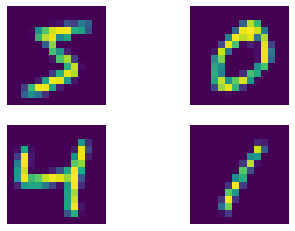

In [4]:
fig = plt.figure()
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(images[0].cpu())
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(images[1].cpu())
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(images[2].cpu())
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(images[3].cpu())
plt.axis('off')

## Model: deep structural causal model

The following code models morphological transformations of MNIST,
defining a causal generative model over digits that contains endogenous
variables to control the width $t$ and intensity $i$ of the stroke:

In [5]:
class ConstantParamTransformModule(dist.torch_transform.TransformModule):
    def __init__(self, transform: Transforms.Transform):
        super().__init__()
        self._transform = transform
        self.domain = transform.domain
        self.codomain = transform.codomain
        self.bijective = transform.bijective
        
    @property
    def sign(self):
        return self._transform.sign
        
    def _call(self, x):
        return self._transform(x)
    
    def _inverse(self, y):
        return self._transform.inv(y)
    
    def log_abs_det_jacobian(self, x, y):
        return self._transform.log_abs_det_jacobian(x, y)


class ComposeTransformModule(Transforms.ComposeTransformModule):
    def __init__(self, transforms: List[Transforms.Transform]):
        super().__init__([
            ConstantParamTransformModule(t) if not isinstance(t, torch.nn.Module) else t for t in transforms
        ])


class ConditionalComposeTransformModule(dist.conditional.ConditionalTransformModule):
    def __init__(self, transforms: List):
        self.transforms = [
            dist.conditional.ConstantConditionalTransform(t)
            if not isinstance(t, dist.conditional.ConditionalTransform)
            else t
            for t in transforms
        ]
        super().__init__()

    def condition(self, context: torch.Tensor):
        return ComposeTransformModule([t.condition(context) for t in self.transforms])
    

class ConditionalAffineTransform(dist.conditional.ConditionalTransformModule):
    def __init__(self, context_nn: torch.nn.Module, event_dim=0, **kwargs):
        super().__init__(**kwargs)
        self.event_dim = event_dim
        self.context_nn = context_nn

    def condition(self, context):
        loc, log_scale = self.context_nn(context)
        return Transforms.AffineTransform(loc, torch.nn.functional.softplus(log_scale), event_dim=self.event_dim)

In [135]:
class ThicknessTransform(ComposeTransformModule):
    def __init__(self, thickness_size: int, weight: torch.Tensor, bias: torch.Tensor):
        self.thickness_size = thickness_size
        super().__init__([
            Transforms.Spline(thickness_size),
            Transforms.AffineTransform(loc=bias, scale=weight, event_dim=0),
            Transforms.ExpTransform()
        ])


class IntensityTransform(ConditionalComposeTransformModule):
    def __init__(self, intensity_size: int, thickness_size: int, hidden_dims: List[int], weight: torch.Tensor, bias: torch.Tensor):
        self.intensity_size = intensity_size
        self.thickness_size = thickness_size
        self.hidden_dims = hidden_dims
        intensity_nn = pyro.nn.DenseNN(
            thickness_size,
            hidden_dims,
            param_dims=[intensity_size, intensity_size],
            nonlinearity=torch.nn.ReLU()
        )
        super().__init__([
            ConditionalAffineTransform(intensity_nn, event_dim=0),
            Transforms.SigmoidTransform(),
            Transforms.AffineTransform(loc=bias, scale=weight, event_dim=0),
        ])
        self.intensity_nn = intensity_nn


class ImageCouplingLayer(Transforms.ConditionalAffineCoupling):
            
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        *,
        nonlinearity: torch.nn.Module = torch.nn.LeakyReLU()
    ):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        super().__init__(
            self.input_dim // 2,
            pyro.nn.ConditionalDenseNN(
                self.input_dim // 2,
                2,
                [self.hidden_dim * self.input_dim],
                param_dims=[self.input_dim - self.input_dim // 2, self.input_dim - self.input_dim // 2],
                nonlinearity=nonlinearity,
            ),
        )


class ImageTransform(ConditionalComposeTransformModule):

    def __init__(
        self,
        im_size: int,
        input_dim: int,
        hidden_dim: int,
        thickness_size: int,
        intensity_size: int,
        alpha: float,
        num_bits: int,
        *,
        momentum: float = 0.05,
        nonlinearity = torch.nn.LeakyReLU(),
    ):
        preprocess_transform = Transforms.ComposeTransform([
            Transforms.AffineTransform(0., 1. / 2 ** num_bits),
            Transforms.AffineTransform(alpha, (1 - alpha)),
            Transforms.SigmoidTransform().inv,
        ])
        
        f_X = ImageCouplingLayer(input_dim, hidden_dim, nonlinearity=nonlinearity)
        norm1 = Transforms.BatchNorm(input_dim, momentum=momentum)
        perm1 = Transforms.Permute(torch.randperm(input_dim))
        
        img_affine_coupling = ImageCouplingLayer(input_dim, hidden_dim, nonlinearity=nonlinearity)
        norm2 = Transforms.BatchNorm(input_dim, momentum=momentum)
        perm2 = Transforms.Permute(torch.randperm(input_dim))
        
        img_auto = ImageCouplingLayer(input_dim, hidden_dim, nonlinearity=nonlinearity)
        norm3 = Transforms.BatchNorm(input_dim, momentum=momentum)
        
        # output_scaling_net = pyro.nn.DenseNN(2, [hidden_dim, hidden_dim], param_dims=[1, 1])
        # output_scaling = ConditionalAffineTransform(output_scaling_net, event_dim=1)
#         output_scaling = Transforms.ComposeTransform([
#             Transforms.SigmoidTransform(),
#             Transforms.AffineTransform(alpha, (1 - alpha)).inv,
#             Transforms.AffineTransform(0., 1. / 2 ** num_bits).inv,
#         ])
        
        super().__init__([
            preprocess_transform,
            f_X,
            norm1,
            perm1,
            img_affine_coupling,
            norm2,
            perm2,
            img_auto,
            norm3,
            #output_scaling,
        ])
        self.im_size = im_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        # for parameter storage...
        self.preprocess_transform = preprocess_transform
        self.f_X = f_X
        self.norm1 = norm1
        self.perm1 = perm1
        self.img_affine_coupling = img_affine_coupling
        self.norm2 = norm2
        self.perm2 = perm2
        self.img_auto = img_auto
        self.norm3 = norm3
        #self.output_scaling = output_scaling

In [136]:
class DeepSCM(PyroModule):

    def __init__(
        self,
        thickness_transform: ThicknessTransform,
        intensity_transform: IntensityTransform,
        img_transform: ImageTransform,
        *,
        include_thickness: bool = True,
        include_intensity: bool = True,
    ):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.include_thickness = include_thickness
        self.include_intensity = include_intensity
        
        self.thickness_transform = thickness_transform
        self.intensity_transform = intensity_transform
        self.img_transform = img_transform

        # tensor sizes
        self.thickness_size = self.thickness_transform.thickness_size
        self.intensity_size = self.intensity_transform.intensity_size
        self.im_size = self.img_transform.im_size
        self.input_dim = self.im_size * self.im_size

    @staticmethod
    def StandardNormal(*event_shape: int, **kwargs) -> Union[dist.Independent, dist.Normal]:
        return dist.Normal(
            torch.zeros((), **kwargs),
            torch.ones((), **kwargs),
        ).expand(event_shape).to_event(len(event_shape))
    
    @staticmethod
    def cond_dist(
        transform: Union[Transforms.Transform, dist.conditional.ConditionalTransform],
        U_dist: dist.Distribution,
        *contexts: torch.Tensor
    ) -> dist.Distribution:
        if not contexts:
            assert isinstance(transform, Transforms.Transform)
            return dist.TransformedDistribution(U_dist, transform)
        batch_shape = torch.broadcast_shapes(*(c.shape[:-1] for c in contexts))
        context = torch.cat([c.expand(batch_shape + (-1,)) for c in contexts], dim=-1)
        U_dist = U_dist.expand(torch.broadcast_shapes(batch_shape, U_dist.batch_shape))
        return dist.ConditionalTransformedDistribution(U_dist, [transform]).condition(context=context)

    def forward(self):
        # Thickness:
        UT_dist = self.StandardNormal(self.thickness_size, device=self.device)
        T_dist = self.cond_dist(self.thickness_transform, UT_dist)
        T = pyro.sample("T", T_dist.mask(self.include_thickness))

        # Intensity:
        UI_dist = self.StandardNormal(self.intensity_size, device=self.device)
        I_dist = self.cond_dist(self.intensity_transform, UI_dist, T)
        I = pyro.sample("I", I_dist.mask(self.include_intensity))

        # Image:
        UX_dist = self.StandardNormal(self.im_size ** 2, device=self.device)
        X_dist = self.cond_dist(self.img_transform, UX_dist, T, I)
        with pyro.poutine.scale(scale=1. / self.im_size ** 2):
            X = pyro.sample("X", X_dist)

        return X

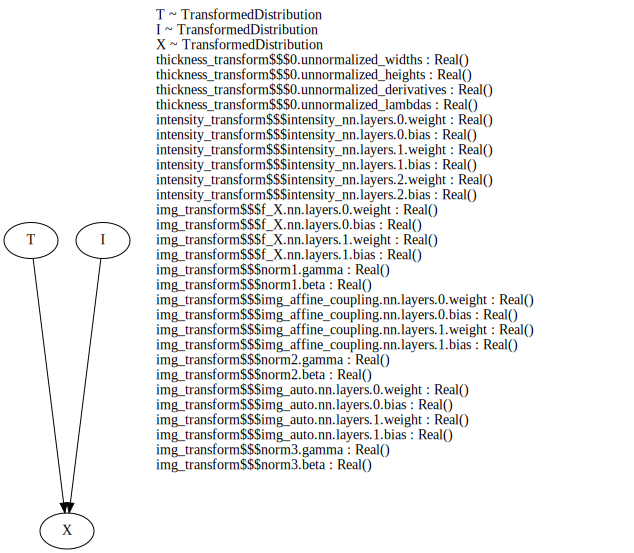

In [137]:
pyro.clear_param_store()

# Thickness parameters
thickness_size = 1
thickness_flow_bias = thickness.log().mean()
thickness_flow_weight = thickness.log().std()

thickness_transform = ThicknessTransform(
    thickness_size,
    thickness_flow_weight[..., None].detach(),
    thickness_flow_bias[..., None].detach()
)

# Intensity parameters
intensity_size = 1
intensity_hidden_dim = 5
intensity_flow_bias = intensity.min()
intensity_flow_weight = intensity.max() - intensity.min()

intensity_transform = IntensityTransform(
    intensity_size,
    thickness_size,
    [intensity_hidden_dim] * 2,
    intensity_flow_weight[..., None].detach(),
    intensity_flow_bias[..., None].detach()
)

# Image parameters
im_size = images.shape[-1]
input_dim = im_size ** 2
img_hidden_dim = 10
alpha = 0.05
num_bits = 3  #* torch.log(torch.as_tensor(im_size)).item()

img_transform = ImageTransform(
    im_size,
    input_dim,
    img_hidden_dim,
    thickness_size,
    intensity_size,
    alpha=alpha,
    num_bits=num_bits,
    nonlinearity=torch.nn.ReLU(),
)

scm = DeepSCM(thickness_transform, intensity_transform, img_transform, include_thickness=False, include_intensity=False)
scm = scm.to(device=curr_device)
pyro.render_model(scm, render_params=True, render_distributions=True)

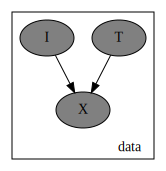

In [138]:
class ConditionedDeepSCM(PyroModule):
    def __init__(self, model: DeepSCM):
        super().__init__()
        self.model = model
        
    def forward(self, t_obs, i_obs, x_obs):
        with pyro.condition(data={"X": x_obs, "T": t_obs, "I": i_obs}), \
                pyro.poutine.scale(scale=1 / x_obs.shape[0]), \
                pyro.plate("data", size=x_obs.shape[0], dim=-1):
            return self.model()

conditioned_model = ConditionedDeepSCM(scm)
pyro.render_model(conditioned_model, model_args=(thickness[:5][..., None], intensity[:5][..., None], images[:5].reshape(-1, im_size*im_size)))

In [139]:
pyro.clear_param_store()

lr_decay = 0.95
initial_lr = 1e-5
adam_params = {"lr": initial_lr} #, "betas": (0.95, 0.999)}
batch_size = 256
num_epochs = 100

dataloader = DataLoader(
    torch.utils.data.TensorDataset(
        thickness[..., None].detach(),
        intensity[..., None].detach(),
        images.reshape(-1, images.shape[-1] ** 2).detach(),
    ),
    batch_size=batch_size,
    shuffle=True
)

guide = pyro.infer.autoguide.AutoDelta(conditioned_model)
elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide)
optimizer = torch.optim.Adam(elbo.parameters(), **adam_params)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)

#elbo = torch.jit.trace(elbo, next(iter(dataloader)))

losses = []
for j in range(num_epochs):
    for i, (t_obs, i_obs, x_obs) in enumerate(dataloader):
        optimizer.zero_grad()
        loss = elbo(t_obs, i_obs, x_obs)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 100 == 0:
            print(f"Epoch {j}, batch {i}: {losses[-1]}")
    scheduler.step()

Epoch 0, batch 0: 26.646177291870117
Epoch 0, batch 100: 16.364002227783203
Epoch 0, batch 200: 14.757111549377441
Epoch 1, batch 0: 14.658082008361816
Epoch 1, batch 100: 14.767887115478516
Epoch 1, batch 200: 14.714831352233887
Epoch 2, batch 0: 14.848043441772461
Epoch 2, batch 100: 14.965642929077148
Epoch 2, batch 200: 14.429343223571777
Epoch 3, batch 0: 14.305461883544922
Epoch 3, batch 100: 13.844612121582031
Epoch 3, batch 200: 13.621527671813965
Epoch 4, batch 0: 13.698339462280273
Epoch 4, batch 100: 13.562868118286133
Epoch 4, batch 200: 14.20223617553711
Epoch 5, batch 0: 15.376070022583008
Epoch 5, batch 100: 16.414485931396484
Epoch 5, batch 200: 17.727069854736328
Epoch 6, batch 0: 18.8656063079834
Epoch 6, batch 100: 19.346153259277344
Epoch 6, batch 200: 20.23540496826172
Epoch 7, batch 0: 20.574909210205078
Epoch 7, batch 100: 20.202390670776367
Epoch 7, batch 200: 20.901287078857422
Epoch 8, batch 0: 21.14459800720215


KeyboardInterrupt: 

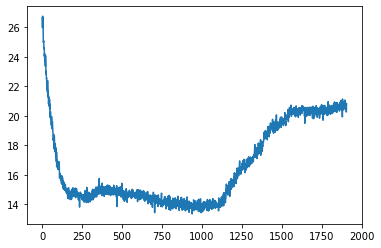

In [140]:
plt.plot(losses)

tensor(67382080.) tensor(-1.1638e+08)


(-0.5, 13.5, 13.5, -0.5)

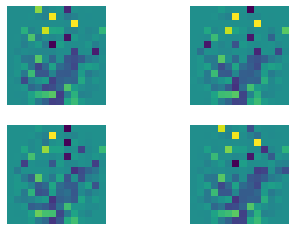

In [154]:
predictive = pyro.infer.Predictive(condition(scm, data = {"T": thickness[0:1][..., None], "I": intensity[0:1][..., None]}), guide=guide, num_samples=4)
img = predictive()["X"]
print((img[0] - img[1]).max(), (img[0] - img[1]).min())

fig = plt.figure()
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(torch.nn.functional.normalize(img[0].cpu().reshape((im_size, im_size))))
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(torch.nn.functional.normalize(img[1].cpu().reshape((im_size, im_size))))
plt.axis('off')
fig.add_subplot(rows, columns, 3)
plt.imshow(torch.nn.functional.normalize(img[2].cpu().reshape((im_size, im_size))))
plt.axis('off')
fig.add_subplot(rows, columns, 4)
plt.imshow(torch.nn.functional.normalize(img[3].cpu().reshape((im_size, im_size))))
plt.axis('off')

## Query: counterfactual data generation

Next we ask a *counterfactual* question: given an observed digit $X$, what
would the digit have been had $t$ been $t + 1$?

To compute this quantity we would normally:
   1. invert the model to find latent exogenous noise $u$
   2. construct an intervened model
   3. re-simulate the forward model on the $u$ [@pearl2011algorithmization].  

However, we can equivalently
represent this process with inference in a single, expanded
probabilistic program containing two copies of every deterministic
statement (a so-called \"twin network\" representation of
counterfactuals, first described in Chapter 7 of [@pearl] and extended
to the PPL setting in [@tavares_2020])

In [ ]:
x_obs = images[0]
plt.imshow(x_obs.cpu().detach().reshape((im_size, im_size)))

In [ ]:
def deep_scm_query(model: DeepSCM):
    def query_model(x_obs):
        with MultiWorldCounterfactual(dim=-1), \
            do(actions={'I': torch.tensor([190.0], device=model.device)}), \
                condition(data={"X": x_obs.reshape(-1, model.input_dim).to(device=model.device)}):
                    return model()
    return query_model

cf_model = pyro.poutine.reparam(config={"X_observed": TransformInferReparam()})(
    deep_scm_query(
        scm
    )
)

In [ ]:
fig = plt.figure()
plt.title("Twin World Counterfactual Model")
plt.axis("off")
plt.tight_layout()
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(cf_model(x_obs)["X"][0][0].cpu().reshape((14, 14)))
plt.title("Actual Model")
plt.axis('off')
fig.add_subplot(rows, columns, 2)
plt.imshow(torch.nn.functional.normalize(cf_model(x_obs)["X"][0][1].cpu().reshape((14, 14))))
plt.title("Intervened Model")
plt.axis('off')

Like all counterfactuals, this estimand is not identified in general
without further assumptions: learning parameters $\theta$ that match
observed data does not guarantee that the counterfactual distribution
will match that of the true causal model. 

However, as discussed in the
original paper [@pawlowski2020deep] in the context of modeling MRI
images, there are a number of valid practical reasons one might wish to
compute it anyway, such as explanation or expert evaluation.

In [ ]:
params = {"intensity_flow_bias": intensity.min(),
"intensity_flow_weight": (intensity.max() - intensity.min()),
"thickness_flow_bias": thickness.log().mean(),
"thickness_flow_weight": thickness.log().std()}

class old_DeepSCM(PyroModule):
    def __init__(self):
        super().__init__()
        
        # Thickness parameters
        thickness_param = Transforms.Spline(1)
        thickness_param.domain = constraints.positive
        self.thickness_param = thickness_param
        
        # Intensity parameters
        intensity_net = pyro.nn.ConditionalAutoRegressiveNN(1, 1, hidden_dims=[10], nonlinearity=torch.nn.Identity())
        intensity_param = Transforms.ConditionalAffineAutoregressive(intensity_net)
        intensity_param.codomain = constraints.positive
        self.intensity_param = intensity_param
        
        # Image parameters
        input_dim = im_size*im_size
        nn_f_X = pyro.nn.ConditionalAutoRegressiveNN(input_dim, 2, [10*input_dim], nonlinearity=torch.nn.Identity())
        f_X = Transforms.ConditionalAffineAutoregressive(nn_f_X, log_scale_min_clip=-1., log_scale_max_clip=5.)
        f_X.domain = constraints.positive
        self.f_X = f_X
        norm = Transforms.BatchNorm(input_dim, momentum=0.05)
        self.norm = norm
        split_dim = input_dim // 2
        param_dims = [input_dim-split_dim, input_dim-split_dim]
#         auto_nn_0 = pyro.nn.AutoRegressiveNN(input_dim, [10*input_dim], nonlinearity=torch.nn.Identity())
#         img_affine_coupling = Transforms.AffineAutoregressive(auto_nn_0, log_scale_min_clip=-1., log_scale_max_clip=5.)
        nn_affine_coupling = pyro.nn.DenseNN(split_dim, [10*input_dim], param_dims, nonlinearity=torch.nn.LeakyReLU())
        img_affine_coupling = Transforms.AffineCoupling(split_dim, nn_affine_coupling, log_scale_min_clip=-1., log_scale_max_clip=5.0)
        self.img_affine_coupling = img_affine_coupling
        
#         auto_nn = pyro.nn.AutoRegressiveNN(input_dim, [10*input_dim], nonlinearity=torch.nn.Identity())
#         img_auto = Transforms.AffineAutoregressive(auto_nn, log_scale_min_clip=-1., log_scale_max_clip=5.)
        nn_affine_coupling_2 = pyro.nn.DenseNN(split_dim, [10*input_dim], param_dims, nonlinearity=torch.nn.LeakyReLU())
        img_auto = Transforms.AffineCoupling(split_dim, nn_affine_coupling_2, log_scale_min_clip=-1., log_scale_max_clip=5.0)
        self.img_auto = img_auto
        norm_2 = Transforms.BatchNorm(input_dim, momentum=0.05)
        self.norm_2 = norm_2
    
    def forward(self):
        # Thickness:
        UT = dist.Normal(torch.tensor(0., device=curr_device), torch.tensor(1., device=curr_device)).expand([1]).to_event(1)
        thickness_flow_loc = params["thickness_flow_bias"]
        thickness_flow_scale = params["thickness_flow_weight"]
        thickness_flow_lognorm = Transforms.AffineTransform(loc=thickness_flow_loc, scale=thickness_flow_scale)
        t_transforms = [
            self.thickness_param,
            thickness_flow_lognorm,
            Transforms.ExpTransform()
        ]
        T = pyro.sample("T", dist.TransformedDistribution(UT, t_transforms))
        
        # Intensity:
        UI = dist.Normal(torch.tensor(0., device=curr_device), torch.tensor(1., device=curr_device)).expand([1]).to_event(1)
        intensity_flow_loc = params["intensity_flow_bias"]
        intensity_flow_scale = params["intensity_flow_weight"]
        intensity_flow_norm = Transforms.AffineTransform(loc=intensity_flow_loc, scale=intensity_flow_scale)
        intensity_tranforms = [
            self.intensity_param,
            Transforms.SigmoidTransform(), 
            intensity_flow_norm
        ]
#         T = T.expand(torch.broadcast_shapes(T.shape[:-1]) + T.shape[-1:])
        I_ = dist.ConditionalTransformedDistribution(UI, intensity_tranforms)
        I = I_.condition(context=T)
        I = pyro.sample("I", I)

        
        # Image:
        UX = dist.Normal(torch.tensor(0., device=curr_device), torch.tensor(1., device=curr_device)).expand([im_size*im_size]).to_event(1)
        
        # Preprocessing
        alpha = 0.001
        num_bits = 2
        s = Transforms.SigmoidTransform()
        preprocess_transform = Transforms.ComposeTransform([
            Transforms.AffineTransform(0., (1. / 2 ** num_bits)),
            Transforms.AffineTransform(alpha, (1 - alpha)),
            s.inv
        ])
    
        batch_shape = torch.broadcast_shapes(T.shape[:-1], I.shape[:-1])
        T = T.expand(batch_shape + T.shape[-1:])
        I = I.expand(batch_shape + I.shape[-1:])
        
        assert T.shape == I.shape
        
        f_X = self.f_X.condition(context=torch.cat((T, I), dim=-1))
        
#         assert torch.cat((T, I), dim=-1).shape == (2, )
        perm1 = Transforms.Permute(torch.randperm(im_size*im_size, device=curr_device))
        perm2 = Transforms.Permute(torch.randperm(im_size*im_size, device=curr_device))
        
        h_X = dist.TransformedDistribution(UX, [preprocess_transform,
                                                f_X,
                                                self.norm,
                                                perm1,
                                                self.img_affine_coupling,
                                                perm2,
                                                self.img_auto,
                                                self.norm_2
                                               ])
        with pyro.poutine.scale(scale=1/(im_size*im_size)):
            X = pyro.sample("X", h_X)
        return X

# scm = DeepSCM().to(device=curr_device)
# print(list(dict(scm.named_parameters()).keys()))
# print(pyro.poutine.trace(scm).get_trace().log_prob_sum())
# pyro.render_model(scm)